In [2]:
PATH_TO_BHPTNRSur = "/home/ubuntu/EG-UT/BHPTNRSurrogate"
import numpy as np
import matplotlib.pyplot as plt
import sys
# add the path to the script directory
sys.path.append(PATH_TO_BHPTNRSur)
from surrogates import BHPTNRSur1dq1e4 as bhptsur

cannot import LAL
**** Surrogate loaded: BHPTNRSur1dq1e4 ****


(8.559606914557994e-05+2.4524925240570052e-14j)


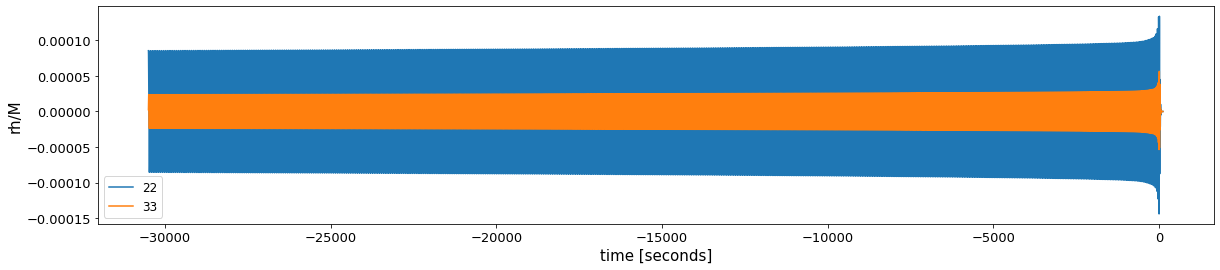

In [3]:
tsur, hsur = bhptsur.generate_surrogate(q=10000)
print(hsur[(2,2)][0])

#print(hsur.keys())

plt.figure(figsize=(20,4))
plt.plot(tsur, np.real(hsur[(2,2)]), '-', label='22')
plt.plot(tsur, np.real(hsur[(3,3)]), '-', label='33')
plt.xlabel('time [seconds]', fontsize=15)
plt.ylabel('rh/M', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)
plt.show()

In [ ]:
!python3 generate_bhpt_dataset.py --n-samples 5000  --q-min 2.5 --q-max 10000

In [4]:
"python3 generate_bhpt_dataset.py --n-samples 256  --q-min 2.5 --q-max 10.0"

import torch
import torch.nn as nn
import architectures as arch
from functools import partial
import argparse
from pathlib import Path
from torchvision.ops import MLP
from data import setup_waveform_dataloaders, WaveformDataset, load_bhpt_tensors
from architectures import SingleConvNeuralNet, GalerkinTransformer
from bhpt_running import train_one_epoch, evaluate_refinement

parser = argparse.ArgumentParser(description="BHPT training script (core logic excerpt).")
parser.add_argument("--data", type=Path, default=Path("bhpt_dataset.pt"), help="Path to the .pt dataset produced by generate_bhpt_dataset.py.")
parser.add_argument("--epochs", type=int, default=1000)
parser.add_argument("--batch-size", type=int, default=8)
parser.add_argument("--lr", type=float, default=1e-6)
parser.add_argument("--weight-decay", type=float, default=1e-4, help="Weight decay (L2 penalty) for Adam optimizer.")
parser.add_argument("--n-timesteps", type=int, default=None, help="Number of temporal frames to sample from the raw data (consistent with notebook).")

parser.add_argument("--share", action="store_true", help="Share weights between modules.")
parser.add_argument("--no-share", dest="share", action="store_false", help="Don't share weights between modules.")
parser.set_defaults(share=True)

parser.add_argument("--refinement", action="store_true", help="Use refinement.")
parser.add_argument("--no-refinement", dest="refinement", action="store_false", help="Don't use refinement.")
parser.set_defaults(refinement=True)

parser.add_argument("--picard", action="store_true", help="Use Picard iterations.")
parser.add_argument("--no-picard", dest="picard", action="store_false", help="Don't use Picard iterations.")
parser.set_defaults(picard=True)

parser.add_argument("--d_model", type=int, default=63)
parser.add_argument("--nhead", type=int, default=4)
parser.add_argument("--dim_feedforward", type=int, default=64)
parser.add_argument("--dropout", type=float, default=0.1)
parser.add_argument("--n_layers", type=int, default=4)
parser.add_argument("--n_modules", type=int, default=1)
parser.add_argument("--q", type=int, default=1)
parser.add_argument("--r", type=float, default=0.5)

args = parser.parse_args("")

Interactive environ: Jupyter themes not found.


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load data from the .pt file into two tensors
waveforms_tensor, params_tensor = load_bhpt_tensors(
    args.data, n_timesteps=args.n_timesteps
)

# 2. Create DataLoaders from the tensors
train_loader, val_loader = setup_waveform_dataloaders(
    waveforms=waveforms_tensor.to(device),
    params=params_tensor.to(device),
    batch_size=args.batch_size
)

# 3. Define dimensions for the model
P = 3  # Positional encoding dimensions (t, y, x)
N, T, H, W, Q = waveforms_tensor.shape
_, n_params = params_tensor.shape

print("DataLoaders are ready.")



Using device: cuda
Loading data from bhpt_dataset.pt...
  Loaded 'waveforms' with shape: torch.Size([5000, 153075, 1, 1, 2])
  Loaded 'params' with shape: torch.Size([5000, 1])
Final tensor shapes: waveforms=torch.Size([5000, 153075, 1, 1, 2]), params=torch.Size([5000, 1])
DataLoaders are ready.


In [6]:
# Cell 3: Model Definition
# For waveform data (H=1, W=1), the "convolution" is just a linear projection.
# Kernel size K and stride S are (1,1).

encoder_out_dim = args.d_model - P

encoder = SingleConvNeuralNet(dim=Q,
    hidden_dim=args.d_model - P,
    out_dim=args.d_model - P,
    hidden_ff=128,
    K=[1, 1],
    S=[1, 1])

encoder = encoder.to(device)

# Dummy forward pass to get the shape for the decoder
with torch.no_grad():
    sample_waveforms = waveforms_tensor[0, None, ...].to(device)
    _, _, H_prime, W_prime, _ = encoder.forward(sample_waveforms).shape
# The decoder's input channels depend on the encoder's output shape
decoder_in_channels = H_prime * W_prime * encoder_out_dim

# The total dimension fed to the transformer will be d_model + n_params
d_model_conditioned = args.d_model + n_params

if args.refinement:
    make_module = partial(arch.GalerkinTransformer,
                          d_model=d_model_conditioned,
                          nhead=args.nhead,
                          dim_feedforward=args.dim_feedforward,
                          dropout=args.dropout,
                          n_layers=args.n_layers)
    process_trajectory = arch.broadcast_initial_conditions
else:
    # Autoregressive training is not implemented for the BHPT case yet
    raise NotImplementedError("Only refinement mode is set up for BHPT training.")

if args.share:
    modules = arch.make_weight_shared_modules(make_module, n_modules=args.n_modules)
else:
    modules = arch.make_weight_unshared_modules(make_module, n_modules=args.n_modules)

if args.picard:
    model = arch.PicardIterations(modules, q=args.q, r=args.r)
else:
    model = arch.ArbitraryIterations(modules)
model = model.to(device)


decoder = MLP(
    in_channels=decoder_in_channels,
    hidden_channels=[64, 256, H * W * Q], # Final output must match original H, W, Q
    activation_layer=nn.ELU,
)

decoder = decoder.to(device)

print(f"Model, Encoder, and Decoder are on device: {next(model.parameters()).device}")
print(f"Transformer d_model: {d_model_conditioned} (divisible by nhead={args.nhead})")

Model, Encoder, and Decoder are on device: cuda:0
Transformer d_model: 64 (divisible by nhead=4)


/usr/lib/python3/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


In [7]:
# The last dimension of the tensor holds the [real, imaginary] parts.
# Let's calculate the complex amplitude (magnitude) for every point.
amplitudes = torch.sqrt(waveforms_tensor[..., 0]**2 + waveforms_tensor[..., 1]**2)

# Now, for each individual waveform in the dataset, find its maximum amplitude over time.
# The time dimension is the second one (dim=1).
peak_amplitudes_per_waveform = torch.max(amplitudes, dim=1).values

# Finally, let's find the min and max of those peak amplitudes.
# This tells us the range of the strongest signals across the whole dataset.
smallest_peak = peak_amplitudes_per_waveform.min().item()
largest_peak = peak_amplitudes_per_waveform.max().item()
mean_peak = peak_amplitudes_per_waveform.mean().item()

print("Analysis of Peak Waveform Amplitudes:")
print(f"  Smallest peak amplitude in the dataset: {smallest_peak:.2e}")
print(f"  Largest peak amplitude in the dataset:  {largest_peak:.2e}")
print(f"  Mean peak amplitude in the dataset:     {mean_peak:.2e}")

Analysis of Peak Waveform Amplitudes:
  Smallest peak amplitude in the dataset: 3.24e-04
  Largest peak amplitude in the dataset:  1.02e+00
  Mean peak amplitude in the dataset:     1.32e-01


In [ ]:
# The optimizer needs to know about all trainable parameters
all_params = list(model.parameters()) + list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.Adam(all_params, lr=args.lr, weight_decay=args.weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=args.epochs)
best_val_loss = float('inf')
best_epoch = 0
save_path = Path("best_bhpt_weights.pt")

print("Starting training...")
for epoch in range(1, args.epochs + 1):
    # Pass nhead to the training and evaluation functions
    train_loss = train_one_epoch(model,
                                 encoder,
                                 decoder,
                                 process_trajectory,
                                 train_loader,
                                 optim)
                                 
    val_loss = evaluate_refinement(model,
                                   encoder,
                                   decoder,
                                   process_trajectory,
                                   val_loader)
    scheduler.step()
    print(f"Epoch {epoch:3d} | train loss: {train_loss:.6f} | val loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': val_loss,
        }, save_path)
        print(f"  -> New best validation loss. Saved model to {save_path}")

torch.save({"state_dict": model.state_dict()}, Path("bhpt_weights.pt"))
print("\nTraining complete. Saved model weights to bhpt_weights.pt")

In [15]:
import sys
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from torchvision.ops import MLP

import architectures as arch
from architectures import SingleConvNeuralNet, GalerkinTransformer
from bhpt_running import pipeline

# ----------------------------------------------------------------------
# 0.  Surrogate model (make sure its repo is on the PYTHONPATH)
# ----------------------------------------------------------------------
PATH_TO_BHPTNRSur = "/home/ubuntu/EG-UT/BHPTNRSurrogate"
if PATH_TO_BHPTNRSur not in sys.path:
    sys.path.append(PATH_TO_BHPTNRSur)
from surrogates import BHPTNRSur1dq1e4 as bhptsur

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
P               = 3     # (t, y, x) positional encodings
d_model         = 63
nhead           = 4
dim_ff          = 64
dropout         = 0.1
n_layers        = 4
n_modules       = 1
q_picard        = 1
r_picard        = 0.5
share_weights   = True

H = W = 1           # spatial size
Q = 2               # (h₊, h×)

encoder_out_dim = d_model - P
encoder = SingleConvNeuralNet(
    dim=Q,
    hidden_dim=encoder_out_dim,
    out_dim=encoder_out_dim,
    hidden_ff=128,
    K=[1, 1],
    S=[1, 1],
).to(device)

make_module = partial(
    GalerkinTransformer,
    d_model=d_model + 1,      # +1 for the scalar mass-ratio parameter
    nhead=nhead,
    dim_feedforward=dim_ff,
    dropout=dropout,
    n_layers=n_layers,
)
modules = (
    arch.make_weight_shared_modules(make_module, n_modules)
    if share_weights else
    arch.make_weight_unshared_modules(make_module, n_modules)
)
model = arch.PicardIterations(modules, q=q_picard, r=r_picard).to(device)

decoder_in = encoder_out_dim * H * W
decoder = MLP(
    in_channels=decoder_in,
    hidden_channels=[64, 256, H * W * Q],
    activation_layer=torch.nn.ELU,
).to(device)

/usr/lib/python3/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


In [29]:
ckpt = torch.load("best_bhpt_weights.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
encoder.load_state_dict(ckpt["encoder_state_dict"])
decoder.load_state_dict(ckpt["decoder_state_dict"])

model.eval(); encoder.eval(); decoder.eval()

# ----------------------------------------------------------------------
# 3.  Build a test input from the surrogate (use ANY q in [2.5, 1e4])
# ----------------------------------------------------------------------
modes_used = (
    (2, 2), (2, -2), (2, 1), (2, -1),
    (3, 3), (3, -3), (3, 2), (3, -2), (3, 1), (3, -1),
    (4, 4), (4, -4), (4, 3), (4, -3), (4, 2), (4, -2),
    (5, 5), (5, -5), (5, 4), (5, -4), (5, 3), (5, -3),
)

q_test = 2.5
tsur, hdict = bhptsur.generate_surrogate(q=q_test)

# Sum the requested modes, then split into plus / cross
h_sum = sum(hdict[m] for m in modes_used)          # complex array
h_plus, h_cross = np.real(h_sum), np.imag(h_sum)   # (T,)

wave_np = np.stack([h_plus, h_cross], axis=-1).astype(np.float32)  # (T, 2)
wave_np = wave_np[:, None, None, :]                                # (T, 1, 1, 2)
wave_t  = torch.from_numpy(wave_np)[None].to(device)               # (1, T, 1, 1, 2)
param_t = torch.tensor([[q_test]], dtype=torch.float32, device=device)

In [30]:
with torch.no_grad():
    pred = pipeline(
        model,
        encoder,
        decoder,
        arch.broadcast_initial_conditions,   # uses only first frame
        wave_t,
        param_t,
    )

pred_np   = pred.squeeze(0).cpu().numpy()[:, 0, 0, :]   # (T, 2)
pred_plus = pred_np[:, 0]

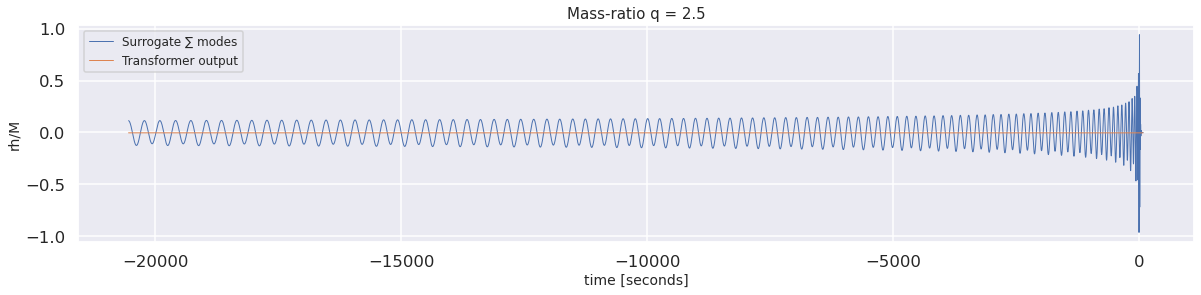

In [31]:
plt.figure(figsize=(20,4))
plt.plot(tsur, h_plus,  label="Surrogate ∑ modes",      lw=1.0)
plt.plot(tsur, pred_plus, label="Transformer output",   lw=1.0)
plt.xlabel("time [seconds]", fontsize=14)
plt.ylabel("rh/M",          fontsize=14)
plt.title(f"Mass-ratio q = {q_test}", fontsize=15)
plt.legend(fontsize=12)
plt.show()